In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime



df = pd.read_csv('covidData.csv')
df = df.reindex(columns= ['Date', 'New Cases', 'Daily Average', 'Seven Day Average', 'Fourteen Day Sum'])
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

#Calculate daily average based on the difference between reporting dates
difference = df.diff(axis=0)['Date']
df['Daily Average'] = df['New Cases']/difference.dt.days
df.dropna(inplace=True, subset=['Daily Average'])

#Make the date the index, then add rows for the missing dates using .asfreq
df = df.set_index(['Date'])
df.sort_index(inplace=True)
df = df.asfreq(freq='1D') #Adds a record for each day currently not in the 

#Backfill daily average
df['Daily Average'] = df['Daily Average'].bfill()

#Calculate 7-day average from rolling average of daily column
df['Seven Day Average'] = df['Daily Average'].rolling(7).mean()
#Create dataframe for 14-day average before removing NA
df['Reporting Date'] = df.index
fourteenDayDF = df.copy()
#Drop NA's from original dataframe
df.dropna(inplace=True, subset=['Seven Day Average'])



fourteenDayDF['Fourteen Day Sum'] = fourteenDayDF['Daily Average'].rolling(14).sum()*100000/110593
fourteenDayDF.dropna(inplace=True, subset=['Fourteen Day Sum'])

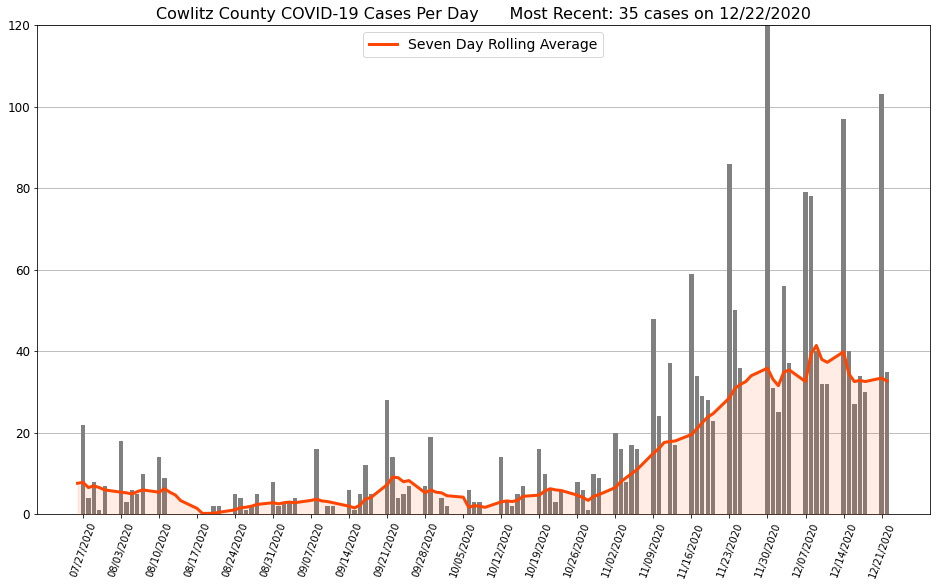

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime

mostRecentCases = int(df.last('1D')['New Cases'].values[0])
mostRecentDate = pd.to_datetime(str(df.last('1D').index.values[0]))
filefriendlyDate = mostRecentDate.strftime("%Y%m%d")
mostRecentDate = mostRecentDate.strftime("%m/%d/%Y")
chartTitle = f"Cowlitz County COVID-19 Cases Per Day      Most Recent: {mostRecentCases} cases on {mostRecentDate}"

#Generate list of labels by filtering for Mondays in the dataframe
filter = (df['Reporting Date'].dt.weekday == 0)
#Create dataframe from filter
mondaysDF = df.loc[filter].copy()
#Move index into list
xlabels = mondaysDF.index.tolist()
#Create two lists for x ticks- one in datetime format and one in string
xlabels = [pd.to_datetime(str(x)).date() for x in xlabels]
xlabelsText = [x.strftime("%m/%d/%Y") for x in xlabels]



plt.figure(figsize=(16,9))
axes = plt.gca()
axes.set_ylim([0,120])
axes.tick_params(axis='y', labelsize=12)


plt.plot(df.index.values, df['Seven Day Average'], color='orangered', linewidth = 3, label='Seven Day Rolling Average', zorder=3)
plt.fill_between(df.index.values, df['Seven Day Average'], alpha = .10, color='orangered', zorder=3)

plt.bar(df.index.values, df['New Cases'], color='grey', zorder=2)

plt.legend(loc="upper center", fontsize = 14)
plt.title(label=chartTitle, fontsize = 16)
plt.grid(axis='y')
plt.xticks(ticks=xlabels, labels=xlabelsText, rotation = 70, horizontalalignment = 'center', va='top')

#https://stackoverflow.com/questions/46961465/different-background-colour-areas-on-matplotlib-plot
plt.show()


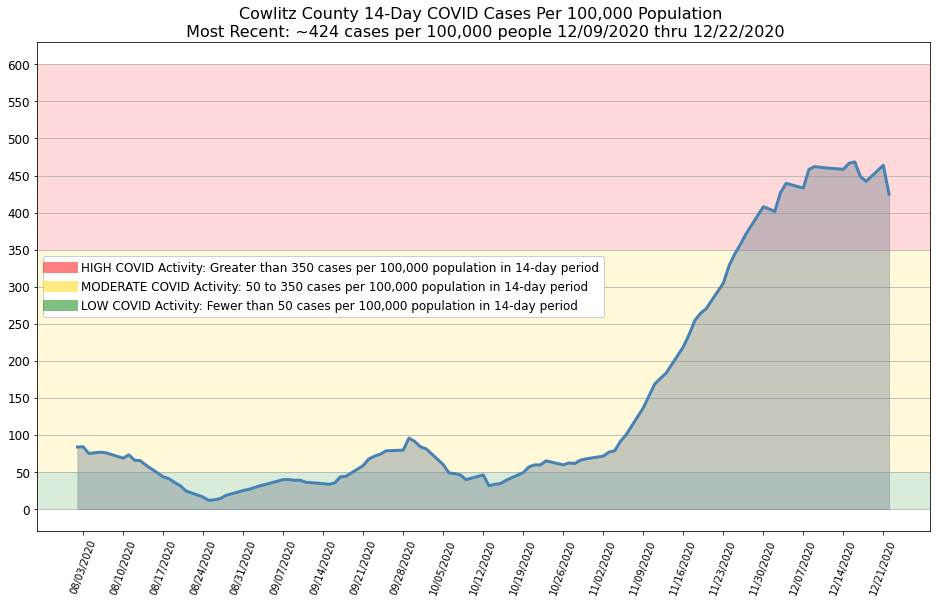

In [24]:
from matplotlib.lines import Line2D

#https://www.doh.wa.gov/Portals/1/Documents/1600/coronavirus/DecisionTree-K12schools.pdf
###Generate colored lines to be used in legend
colors = ['red', 'gold', 'green']
custom_lines = [Line2D([0], [0], color = item, lw=11, alpha= .5) for item in colors]
legendLabels = ["HIGH COVID Activity: Greater than 350 cases per 100,000 population in 14-day period", "MODERATE COVID Activity: 50 to 350 cases per 100,000 population in 14-day period",
"LOW COVID Activity: Fewer than 50 cases per 100,000 population in 14-day period"]

###Generate x labels from Mondays
#Generate list of labels by filtering for Mondays in the dataframe
filter = (fourteenDayDF['Reporting Date'].dt.weekday == 0)
#Create dataframe from filter
mondaysDF = fourteenDayDF.loc[filter].copy()
#Move index into list
xlabels = mondaysDF.index.tolist()
#Create two lists for x ticks- one in datetime format and one in string
xlabels = [pd.to_datetime(str(x)).date() for x in xlabels]
xlabelsText = [x.strftime("%m/%d/%Y") for x in xlabels]

mostRecentFourteenValue = int(fourteenDayDF.last('1D')['Fourteen Day Sum'].values[0])
filelocation = f"{os.getcwd()}\\Graphs\\{filefriendlyDate}14dayperpop.png"
fourteenDaysAgo = pd.to_datetime(str(fourteenDayDF.last('14D').index.values[0]))
fourteenDaysAgo = fourteenDaysAgo.strftime("%m/%d/%Y")
chartTitle = f"Cowlitz County 14-Day COVID Cases Per 100,000 Population \n Most Recent: ~{mostRecentFourteenValue} cases per 100,000 people {fourteenDaysAgo} thru {mostRecentDate}"

plt.figure(figsize=(16,9))
axes = plt.gca()
axes.tick_params(axis='y', labelsize=12)

plt.plot(fourteenDayDF.index.values, fourteenDayDF['Fourteen Day Sum'], color='steelblue', linewidth = 3, zorder=3)
plt.fill_between(fourteenDayDF.index.values, fourteenDayDF['Fourteen Day Sum'], alpha = .40, color='slategrey', zorder=2)

plt.legend(custom_lines, legendLabels, loc='center left', fontsize = 12, framealpha=1)
plt.title(label=chartTitle, fontsize = 16)
plt.grid(axis='y')
plt.yticks(ticks=range(0, 650, 50))
plt.xticks(ticks=xlabels, labels=xlabelsText, rotation = 70, horizontalalignment = 'center', va='top')
plt.gca().axhspan(ymin = 0, ymax = 50, facecolor='green', alpha=.15, zorder= 1)
plt.gca().axhspan(ymin = 50, ymax = 350, facecolor='gold', alpha=.15, zorder= 1)
plt.gca().axhspan(ymin = 350, ymax = 600, facecolor='red', alpha=.15, zorder= 1)

plt.savefig(filelocation, dpi=400, facecolor='white')
